In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from time import time
import urllib.request
from urllib.request import HTTPError

In [30]:
np.random.seed(123456)

In [2]:
train_data = pd.read_csv("C:/Users/User/Desktop/Python/Deep_Learning/CNN/train.csv", engine="python")
test_data = pd.read_csv("C:/Users/User/Desktop/Python/Deep_Learning/CNN/test.csv", engine="python")

In [3]:
print(train_data.shape)
print(test_data.shape)

(1225029, 3)
(117703, 2)


# Preprocessing Scheme

In [45]:
"""
우리의 사진은 120만개 정도 됨.
한 랜드마크에 대해서 너무 많은 사진이 있기도 하고(5만 개)
너무 적은 사진이 있기도 하다(1개)
일단 해야 할 것은 너무 적은 사진들은 학습이 잘 되지 않을 것이라는 측면에서 잘라내고,
500번 이상 나온 것들에 대해서만 training set/validation set을 만든다.
그러면 두 가지 경우가 존재한다.
1) 하나의 landmark_id에 대해 500번 이상 1200번 미만 나온 사진
2) 하나의 landmark_id에 대해 1200번 이상 나온 사진

1)에 해당하는 landmark_id에 대해서는 그에 상응하는 사진을 1200개로 만들어 준다.
(photo generation: without replacement sampling을 (1200/N)번 시행. N = landmark_id 출현 횟수)
2)에 해당하는 landmark_id에 대해서도 그에 상응하는 사진을 1200개로 만들어 준다.
(photo sampling: without replacement)
--> np.random.choice를 사용하는게 좋지 않을까 싶음.
그런 후 사진들이 1200개씩 있을텐데, 사진이 순서대로 쌓여있을 것이다.
전체 사진이 1200*(# of classes, i.e. # of landmark_id's)개 만큼 있을텐데,
이 사진들을 적절히 shuffling 해주는 것이 컴퓨터가 학습하는데 있어 필요하다.
"""

"\n우리의 사진은 120만개 정도 됨.\n한 랜드마크에 대해서 너무 많은 사진이 있기도 하고(5만 개)\n너무 적은 사진이 있기도 하다(1개)\n일단 해야 할 것은 너무 적은 사진들은 학습이 잘 되지 않을 것이라는 측면에서 잘라내고,\n500번 이상 나온 것들에 대해서만 training set/validation set을 만든다.\n그러면 두 가지 경우가 존재한다.\n1) 하나의 landmark_id에 대해 500번 이상 1200번 미만 나온 사진\n2) 하나의 landmark_id에 대해 1200번 이상 나온 사진\n\n1)에 해당하는 landmark_id에 대해서는 그에 상응하는 사진을 1200개로 만들어 준다.\n(photo generation: without replacement sampling을 (1200/N)번 시행. N = landmark_id 출현 횟수)\n2)에 해당하는 landmark_id에 대해서도 그에 상응하는 사진을 1200개로 만들어 준다.\n(photo sampling: without replacement)\n--> np.random.choice를 사용하는게 좋지 않을까 싶음.\n그런 후 사진들이 1200개씩 있을텐데, 사진이 순서대로 쌓여있을 것이다.\n전체 사진이 1200*(# of classes, i.e. # of landmark_id's)개 만큼 있을텐데,\n이 사진들을 적절히 shuffling 해주는 것이 컴퓨터가 학습하는데 있어 필요하다.\n"

In [46]:
train_data.head()

,id,url,landmark_id
0,cacf8152e2d2ae60,http://static.panoramio.com/photos/original/70...,4676
1,0a58358a2afd3e4e,http://lh6.ggpht.com/-igpT6wu0mIA/ROV8HnUuABI/...,6651
2,6b2bb500b6a38aa0,http://lh6.ggpht.com/-vKr5G5MEusk/SR6r6SJi6mI/...,11284
3,b399f09dee9c3c67,https://lh3.googleusercontent.com/-LOW2cjAqubA...,8429
4,19ace29d77a5be66,https://lh5.googleusercontent.com/-tnmSXwQcWL8...,6231


In [47]:
freq_rank =  pd.DataFrame(train_data.landmark_id.value_counts())
freq_rank.reset_index(inplace=True)
freq_rank.head()

,index,landmark_id
0,9633,50337
1,6051,50148
2,6599,23415
3,9779,18471
4,2061,13271


In [48]:
freq_rank.columns = ['landmark_id','count']
freq_rank_top10 = freq_rank[:10]
freq_rank_top10

,landmark_id,count
0,9633,50337
1,6051,50148
2,6599,23415
3,9779,18471
4,2061,13271
5,5554,11147
6,6651,9508
7,6696,9222
8,5376,9216
9,2743,8997


In [49]:
freq_rank_ge500 = freq_rank[freq_rank['count'] >= 500]
freq_rank_ge500.tail()

,landmark_id,count
380,11082,502
381,10277,501
382,351,500
383,14565,500
384,5919,500


In [50]:
print(round(freq_rank_ge500['count'].sum(axis=0)/train_data.shape[0], 4))
# 하나의 landmark id가 500번 이상 나타나는 사진의 빈도는 50%라고 할 수 있다. 
# 이것을 우리의 training set을 만드는데 있어 baseline으로 한다.
print(freq_rank_ge500.describe())

0.5
        landmark_id         count
count    385.000000    385.000000
mean    7304.753247   1590.919481
std     4235.382034   4113.765223
min       95.000000    500.000000
25%     3611.000000    613.000000
50%     7416.000000    784.000000
75%    10855.000000   1106.000000
max    14902.000000  50337.000000


In [51]:
freq_rank_ge1200 = freq_rank_ge500[freq_rank_ge500['count'] >= 1200]
print(freq_rank_ge1200.shape)
freq_rank_ge1200.head()

(85, 2)


,landmark_id,count
0,9633,50337
1,6051,50148
2,6599,23415
3,9779,18471
4,2061,13271


In [52]:
freq_rank_lt1200 = freq_rank_ge500[freq_rank_ge500['count'] < 1200]
print(freq_rank_lt1200.shape)
freq_rank_lt1200.head()
#freq_rank_lt1200.tail()

(300, 2)


,landmark_id,count
85,1546,1193
86,7764,1191
87,4644,1183
88,9605,1179
89,7420,1163


In [56]:
train_data1 = pd.merge(train_data, freq_rank_ge500, how = 'inner')
train_data1 = train_data1.sort_values(by='count', ascending=False)
train_data1 = train_data1.groupby(['landmark_id'], as_index = False)
train_data1.describe()

landmark_id                                                             \
          count     mean  std      min      25%      50%      75%      max   
0         580.0     95.0  0.0     95.0     95.0     95.0     95.0     95.0   
1        1218.0    152.0  0.0    152.0    152.0    152.0    152.0    152.0   
2        1599.0    165.0  0.0    165.0    165.0    165.0    165.0    165.0   
3         642.0    193.0  0.0    193.0    193.0    193.0    193.0    193.0   
4         518.0    207.0  0.0    207.0    207.0    207.0    207.0    207.0   
5        1602.0    233.0  0.0    233.0    233.0    233.0    233.0    233.0   
6         985.0    253.0  0.0    253.0    253.0    253.0    253.0    253.0   
7         591.0    328.0  0.0    328.0    328.0    328.0    328.0    328.0   
8         500.0    351.0  0.0    351.0    351.0    351.0    351.0    351.0   
9         667.0    355.0  0.0    355.0    355.0    355.0    355.0    355.0   
10        662.0    362.0  0.0    362.0    362.0    362.0    362.0    362.0   
11        822.0    384.0  0.0    384.0    384.0    384.0    384.0    384.0   
12        592.0    395.0  0.0    395.0    395.0    395.0    395.0    395.0   
13        592.0    415.0  0.0    415.0    415.0    415.0    415.0    415.0   
14       3171.0    428.0  0.0    428.0    428.0    428.0    428.0    428.0   
15        589.0    461.0  0.0    461.0    461.0    461.0    461.0    461.0   
16        813.0    515.0  0.0    515.0    515.0    515.0    515.0    515.0   
17        522.0    623.0  0.0    623.0    623.0    623.0    623.0    623.0   
18        729.0    626.0  0.0    626.0    626.0    626.0    626.0    626.0   
19        567.0    680.0  0.0    680.0    680.0    680.0    680.0    680.0   
20        567.0    725.0  0.0    725.0    725.0    725.0    725.0    725.0   
21        891.0    762.0  0.0    762.0    762.0    762.0    762.0    762.0   
22        596.0    784.0  0.0    784.0    784.0    784.0    784.0    784.0   
23        836.0    793.0  0.0    793.0    793.0    793.0    793.0    793.0   
24        763.0    823.0  0.0    823.0    823.0    823.0    823.0    823.0   
25        557.0    868.0  0.0    868.0    868.0    868.0    868.0    868.0   
26       1299.0    878.0  0.0    878.0    878.0    878.0    878.0    878.0   
27       1232.0    960.0  0.0    960.0    960.0    960.0    960.0    960.0   
28        725.0   1031.0  0.0   1031.0   1031.0   1031.0   1031.0   1031.0   
29        724.0   1046.0  0.0   1046.0   1046.0   1046.0   1046.0   1046.0   
..          ...      ...  ...      ...      ...      ...      ...      ...   
355      1046.0  13471.0  0.0  13471.0  13471.0  13471.0  13471.0  13471.0   
356      1459.0  13475.0  0.0  13475.0  13475.0  13475.0  13475.0  13475.0   
357      8667.0  13526.0  0.0  13526.0  13526.0  13526.0  13526.0  13526.0   
358       708.0  13532.0  0.0  13532.0  13532.0  13532.0  13532.0  13532.0   
359       667.0  13552.0  0.0  13552.0  13552.0  13552.0  13552.0  13552.0   
360      1371.0  13594.0  0.0  13594.0  13594.0  13594.0  13594.0  13594.0   
361       652.0  13622.0  0.0  13622.0  13622.0  13622.0  13622.0  13622.0   
362      1790.0  13653.0  0.0  13653.0  13653.0  13653.0  13653.0  13653.0   
363       689.0  13678.0  0.0  13678.0  13678.0  13678.0  13678.0  13678.0   
364       681.0  13707.0  0.0  13707.0  13707.0  13707.0  13707.0  13707.0   
365       593.0  13775.0  0.0  13775.0  13775.0  13775.0  13775.0  13775.0   
366      1422.0  13873.0  0.0  13873.0  13873.0  13873.0  13873.0  13873.0   
367       719.0  13875.0  0.0  13875.0  13875.0  13875.0  13875.0  13875.0   
368      1348.0  13876.0  0.0  13876.0  13876.0  13876.0  13876.0  13876.0   
369       809.0  13887.0  0.0  13887.0  13887.0  13887.0  13887.0  13887.0   
370       824.0  14012.0  0.0  14012.0  14012.0  14012.0  14012.0  14012.0   
371       593.0  14044.0  0.0  14044.0  14044.0  14044.0  14044.0  14044.0   
372       556.0  14105.0  0.0  14105.0  14105.0  14105.0  14105.0  14105.0   
373       926.0  14111.0  

In [15]:
9633 in list(freq_rank_ge500['landmark_id'])

True

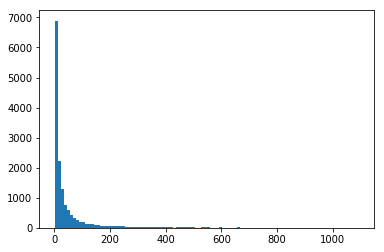

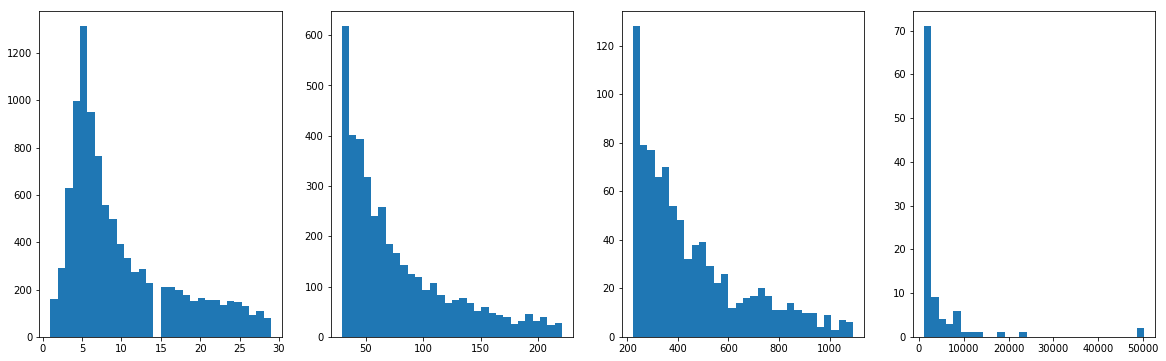

In [15]:
plt.hist(freq_rank["count"][100:], bins=100)

fig = plt.figure(figsize=(20,6))
ax1 = fig.add_subplot(141)
ax2 = fig.add_subplot(142)
ax3 = fig.add_subplot(143)
ax4 = fig.add_subplot(144)

ax1.hist(freq_rank["count"][5000:], bins=30)
ax2.hist(freq_rank["count"][1000:5000], bins =30)
ax3.hist(freq_rank["count"][100:1000], bins=30)
ax4.hist(freq_rank["count"][:100], bins=30)

plt.show()


In [16]:
"""명소의 빈도의 분포를 확인 결과, 100미만의 낮은 빈도를 가지는 명소의 수가 압도적으로 많았으며, 그중에서도 5~7번 정도 나타나는 경우가 많았습니다. 
또한 수천번 이상 나타나는 최고빈도 명소들도 있었으며, 5만여번 나타난 outlier들도 있었습니다. """

'명소의 빈도의 분포를 확인 결과, 100미만의 낮은 빈도를 가지는 명소의 수가 압도적으로 많았으며, 그중에서도 5~7번 정도 나타나는 경우가 많았습니다. \n또한 수천번 이상 나타나는 최고빈도 명소들도 있었으며, 5만여번 나타난 outlier들도 있었습니다. '

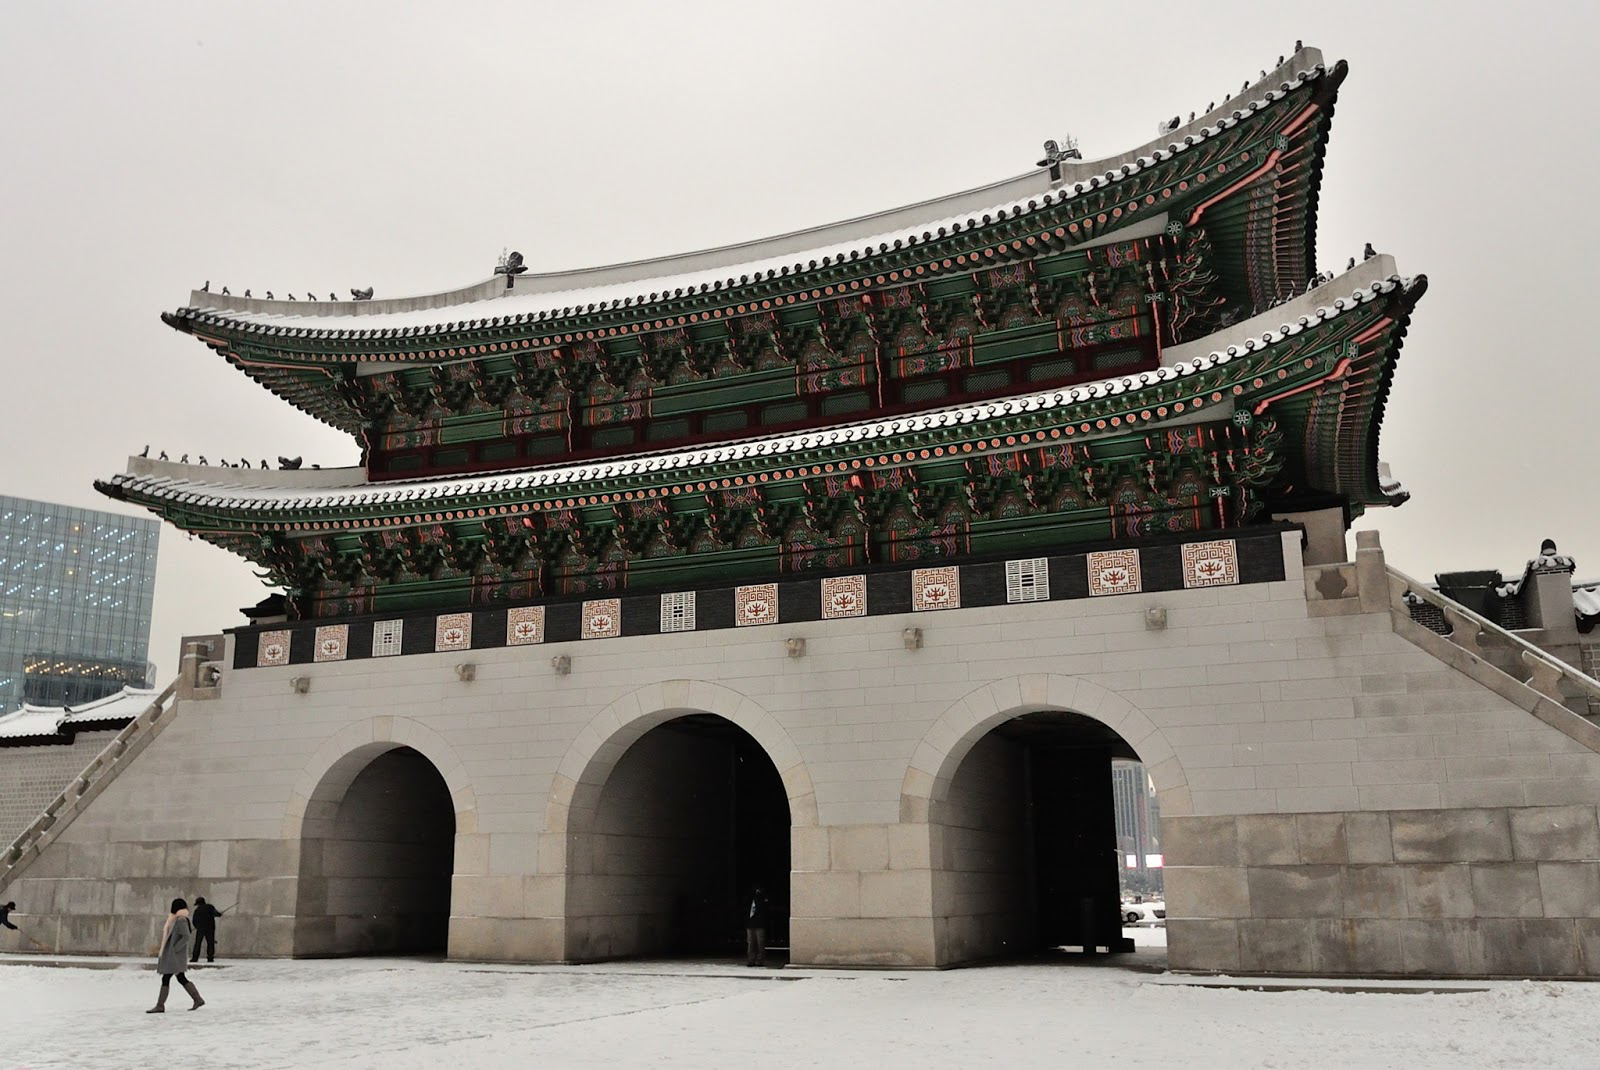

In [124]:
image1 = Image.open("D:/DL_pictures/train354.png")
image1

In [ ]:
urls = train_data['url']

tic = time()
for i, url in enumerate(urls[:1000]):
    try:
        urllib.request.urlretrieve(url,'D:/DL_pictures/train%d.png' % (i+1))
        ## 첫번째 인수: 사진에 해당하는 url 주소, 두번째 인수: 저장할 사진 이름.
    except HTTPError as e:
        print(e, '%d'%(i+1))
toc = time()
print("Took %.2f seconds."%(toc-tic))

HTTP Error 404: Not Found 42
HTTP Error 403: Forbidden 129
HTTP Error 403: Forbidden 236
HTTP Error 404: Not Found 257


In [46]:
### 이 코드가 구동되려면 재환이형이 만든 사진 다운로드 코드를 먼저 시행해야됨

# 사진들을 3D tensor(세로, 가로, RGB)형태로 리스트에 저장함!! 이 텐서가 CNN모델에 먹일 dataset 이 됨
pic_tensor_train = []

# 사진 파일들의 가로세로 픽셀수를 확인
pixel_size_list = []


for i in range(1000):
    try:
        url = "D:/DL_pictures/train" + str(i+1) + ".png"
        image = Image.open(url)
        tensor = np.array(image)
        
        pic_tensor_train.append(tensor)
        pixel_size_list.append(tensor.shape[:2])
        
    except FileNotFoundError:
        print("file train%d does not exist" % (i+1))
        
pixel_size_list = np.array(pixel_size_list)

file train42 does not exist
file train129 does not exist
file train236 does not exist
file train257 does not exist
file train276 does not exist
file train454 does not exist
file train548 does not exist
file train619 does not exist
file train873 does not exist


In [126]:
# dataset으로 쓸 3d tensor가 잘 처리되어 저장되었는지 확인
pic_tensor_train[1]

array([[[170, 173, 188],
        [168, 171, 186],
        [168, 171, 186],
        ...,
        [182, 185, 200],
        [182, 185, 200],
        [182, 185, 200]],

       [[168, 174, 188],
        [167, 173, 187],
        [166, 172, 186],
        ...,
        [181, 187, 201],
        [181, 187, 201],
        [181, 187, 201]],

       [[168, 174, 188],
        [167, 173, 187],
        [166, 172, 186],
        ...,
        [182, 188, 202],
        [182, 188, 202],
        [182, 188, 202]],

       ...,

       [[ 26,  37,  65],
        [ 24,  36,  62],
        [ 25,  37,  63],
        ...,
        [ 62,  73,  67],
        [ 63,  76,  69],
        [ 62,  75,  68]],

       [[ 24,  36,  62],
        [ 24,  36,  60],
        [ 26,  38,  62],
        ...,
        [ 58,  71,  62],
        [ 60,  73,  64],
        [ 61,  74,  65]],

       [[ 27,  37,  62],
        [ 28,  40,  64],
        [ 28,  40,  62],
        ...,
        [ 58,  71,  62],
        [ 59,  75,  65],
        [ 59,  75,  65]]

   pixel_ratio  count
0         0.75    518
1         0.67    141
2         1.33    138
3         0.66     50
4         1.50     38
5         1.00     23

max ratio:  1.6701461377870563
min ratio:  0.5625


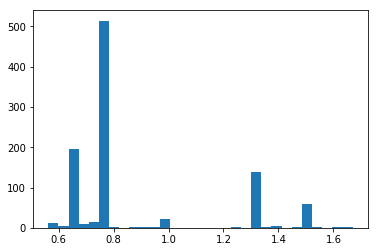

In [115]:
###사진의 가로세로 배율을 확인. 이 부분은 이후 CNN모델에 동일한 규격의 사진을 입력하기 위한 전처리를 위해 꼭 확인해야하는 정보임

# 세로 픽셀수를 가로 픽셀수로 나누어 배율을 확인
pixel_ratio = pixel_size_list[:,0] /pixel_size_list[:,1]


pixel_ratio_count = pd.DataFrame(pd.Series(np.round(pixel_ratio, 2)).value_counts())
pixel_ratio_count.reset_index(inplace=True)
pixel_ratio_count.columns = ['pixel_ratio','count']
print(pixel_ratio_count.head(6))


print("\nmax ratio: ",np.max(pixel_ratio))
print("min ratio: ", np.min(pixel_ratio))

plt.hist(pixel_ratio, bins=30)
plt.show()

In [ ]:
# 대부분의 사진이 3X4, 2X3, 4X3, 3X2, 1X1의 배율임을 확인할 수 있다. 
# 세로로 가장 긴 사진은 5:3 정도의 배율이며, 가로로 가장 긴 사진은 9:16 배율이다.
#데이터들의 배율 차이가 극명하게 나므로, 사진의 전처리 과정이 매우 중요해지게 된다.